# Preparation

## Loading libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
%matplotlib inline 


plt.style.use('seaborn-bright')
plt.rc('font', size=15) 
colors = ["#1f18da", "#e42d5b", "#00d8a3", "#313131", "#ffb92a"]
sns.set_palette(sns.color_palette(colors))

## Load data

In [47]:
df = pd.read_csv(
    "./coffee-modified.csv", sep=",")

print("Elements: {}".format(df.size))
print("Shape: {}".format(df.shape))

Elements: 58036
Shape: (1319, 44)


## Look at data

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1312 non-null   object 
 1   Species                1319 non-null   object 
 2   Owner                  1310 non-null   object 
 3   Country.of.Origin      1316 non-null   object 
 4   Farm.Name              961 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1007 non-null   object 
 7   ICO.Number             1169 non-null   object 
 8   Company                1105 non-null   object 
 9   Altitude               1092 non-null   object 
 10  Region                 1257 non-null   object 
 11  Producer               1084 non-null   object 
 12  Number.of.Bags         1314 non-null   object 
 13  Bag.Weight             1314 non-null   object 
 14  In.Country.Partner     1314 non-null   object 
 15  Harv

In [49]:
pd.set_option("max_columns", 100)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318
ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,11/23/0101,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1312
Species,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,...,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,"unex guatemala, s.a.",Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica
Owner,metad plc,metad plc,grounds for health admin,yidnekachew dabessa,metad plc,ji-ae ahn,hugo valdivia,ethiopia commodity exchange,ethiopia commodity exchange,diamond enterprise plc,mohammed lalo,cqi q coffee sample representative,cqi q coffee sample representative,grounds for health admin,ethiopia commodity exchange,cqi q coffee sample representative,grounds for health admin,ethiopia commodity exchange,yunnan coffee exchange,essencecoffee,cqi q coffee sample representative,the coffee source inc.,roberto licona franco,cqi q coffee sample representative,ji-ae ahn,nucoffee,ethiopia commodity exchange,kabum trading company,bismarck castro,"lin, che-hao krude ???",nora zeas,specialty coffee-korea,nucoffee,francisco a mena,hider abamecha,daniel magu,kona pacific farmers cooperative,kona pacific farmers cooperative,ethiopia commodity exchange,cqi q coffee sample representative,itdp international,jacques pereira carneiro,jacques pereira carneiro,"lin, che-hao krude ???",jungle estate,nucoffee,great lakes coffee uganda,lusso lab,lusso lab,afca,...,juan luis alvarado romero,homero antonio de anda andrade,juan luis alvarado romero,juan luis alvarado romero,eileen koyanagi,eileen koyanagi,israel eduardo paz garcia,william ho,guillermo eduardo bobadilla muguira,cafes finos de exportacion s de r.l.,ana gonzales,volcafe ltda. - brasil,juan luis alvarado romero,juan luis alvarado romero,juana rodriguez gutierrez,francisco hernandez lorenzo,montegrande,martin jimenez casiano,"grupo juvenil magtayani, ac",israel eduardo paz garcia,pablo enrique martinez gama,juan luis alvarado romero,juan luis alvarado romero,NaN,nestor mendez gomez,eileen koyanagi,juan luis alvarado romero,jorge octavio escamilla prado,myrna roxana galvez gonzalez,eugene holman pew,kona pacific farmers cooperative,bourbon specialty coffees,cafes finos de exportacion s de r.l.,kurt kappeli,honor dela fuente,eileen koyanagi,myriam kaplan-pasternak,santa laura exportadora de cafe s.l.e.c. s.a.,jose armando norberto borzani lemini,ricardo aaron sampieri marini,kurt kappeli,volcafe ltda. - brasil,cadexsa,cadexsa,cadexsa,juan carlos garcia lopez,myriam kaplan-pasternak,"exportadora atlantic, s.a.",juan luis alvarado romero,bismarck castro
Country.of.Origin,Ethiopia,Ethiopia,Guatemala,Ethiopia,Ethiopia,Brazil,Peru,Ethiopia,Ethiopia,Ethiopia,Ethiopia,United States,United States,United St

## Clean data

### Defining cleaning functions

In [50]:
def copy_df(df):
    df_copy = df.copy()
    return df_copy

In [51]:
def drop_rows_with_undefined_vals(df, col):
    isList = isinstance(col, list)
    subset = col if isList else [col]
    entries_before = df.shape[0]
    df.dropna(subset=subset, inplace=True)
    entries_after = df.shape[0]
    print("Removed {} entries in column {} containing undefined or missing values.".format(entries_before - entries_after, col))

    return df


In [52]:
def convert_data_types(df):
    df = df.convert_dtypes()
    return df

In [53]:
def select_only_species(df, species):
    entries_before = df.shape[0]
    df = df[df.Species == species]
    entries_after = df.shape[0]
    print("Removed {} entries not being of Species {}.".format(entries_before - entries_after, species))
    return df

In [54]:
def drop_unnecessary_cols(df, cols):
    df = df.drop(labels=cols, axis=1)
    return df

In [55]:
def convert_to_string(df, col):
    df[col] = df[col].astype('|S')
    return df

In [56]:
def convert_to_num(df, col):
    df[col] = pd.to_numeric(df[col])
    return df


In [57]:
def convert_to_int(df, col):
    df[col] = df[col].astype("int32")
    return df

In [58]:
def correct_altitude_values(df):
    #select row whrere region is of type cerrado and altitude is higher than 5000; move comma by one position to land in correct range (decimeter -> meter)
    df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 10

    #take every row above 6000 meters and convert from cm to meters by dividing by 100
    df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 100
    return df

In [59]:
def remove_zero_total_cup_results(df):
    entries_before = df.shape[0]
    df = df[df["Total.Cup.Points"] > 0]
    entries_after = df.shape[0]
    print("Removed {} entries where total cup results were equal to zero.".format(entries_before - entries_after))
    return df

In [60]:
def remove_none_values(df, col):
    entries_before = df.shape[0]
    df = df[~df[col].isin(["None", "none"])]
    entries_after = df.shape[0]
    print("Removed {} entries from {} because they were None/none.".format((entries_before - entries_after), col))
    return df

In [61]:
def remove_kg_units_from_weight(df):
    df["Bag.Weight"] = df["Bag.Weight"].apply(lambda row: str.replace(row, " kg", ""))
    return df

In [62]:
def remove_lbs_units_from_weight(df):
    df["Bag.Weight"] = df["Bag.Weight"].apply(lambda row: str.replace(row, " lbs", ""))
    return df

In [63]:
def calculate_total_weight(df):
    df["Weight.Total"] = df["Bag.Weight.Kg"] * df["Number.of.Bags"]
    return df

In [64]:
def convert_weight_to_kg(df):
    df["Bag.Weight.Kg"] = df.apply(pound_kg_conversion, axis=1)
    return df


def pound_kg_conversion(row):
    weight = row["Bag.Weight"]
    if "kg" in weight:
        return str.replace(weight, " kg", "")
    elif "lbs" in weight:
        weight = str.replace(weight, " lbs", "")
        weight_int = int(weight)
        return 0.453592 * weight_int



In [99]:
def remove_outliers(df, col):
    entries_before = df.shape[0]
    df = df[(np.abs(stats.zscore(df[col])) < 3)]
    entries_after = df.shape[0]
    print("Removed {} entries from {} because they were outliers.".format((entries_before - entries_after), col))
    return df

### Piping dataframe through cleaning functions

In [100]:
metric_features = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body",
                   "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]
df_type_adjusted = (df.pipe(copy_df)
                    .pipe(convert_data_types)
                    .pipe(drop_rows_with_undefined_vals, metric_features)
                    .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                    .pipe(drop_rows_with_undefined_vals, "Color")
                    .pipe(convert_to_num, "Cupper.Points")
                    .pipe(convert_to_num, "Total.Cup.Points")
                    .pipe(convert_to_num, "Number.of.Bags")
                    .pipe(convert_weight_to_kg)
                    .pipe(convert_to_num, "Bag.Weight.Kg")
                    .pipe(calculate_total_weight)

                    )
print("New data shape: {}".format(df_type_adjusted.shape))

unnecessary_cols = ["Lot.Number", "Farm.Name", "Mill", "Company", "Altitude", "Producer", "In.Country.Partner",
                    "Owner.1", "Certification.Address", "Certification.Contact", "Owner", "Certification.Body"]

df_cleaned = (df.pipe(copy_df)
                .pipe(convert_data_types)
                .pipe(drop_unnecessary_cols, unnecessary_cols)
                .pipe(drop_rows_with_undefined_vals, metric_features)
                .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                .pipe(drop_rows_with_undefined_vals, "Color")
                .pipe(drop_rows_with_undefined_vals, "Processing.Method")
                .pipe(remove_none_values, "Color")
                .pipe(select_only_species, "Arabica")
                .pipe(convert_to_num, "Cupper.Points")
                .pipe(convert_to_num, "Total.Cup.Points")
                .pipe(convert_to_num, "Number.of.Bags")
                .pipe(convert_weight_to_kg)
                .pipe(convert_to_num, "Bag.Weight.Kg")
                .pipe(remove_zero_total_cup_results)
                .pipe(correct_altitude_values)
                .pipe(calculate_total_weight)
                .pipe(remove_outliers, "Weight.Total")
              )
print("New data shape: {}".format(df_cleaned.shape))


Removed 12 entries in column ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points'] containing undefined or missing values.
Removed 0 entries in column Total.Cup.Points containing undefined or missing values.
Removed 215 entries in column Color containing undefined or missing values.
New data shape: (1092, 46)
Removed 12 entries in column ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points'] containing undefined or missing values.
Removed 0 entries in column Total.Cup.Points containing undefined or missing values.
Removed 215 entries in column Color containing undefined or missing values.
Removed 32 entries in column Processing.Method containing undefined or missing values.
Removed 51 entries from Color because they were None/none.
Removed 0 entries not being of Species Arabica.
Removed 0 entries where total cup results were equal to zero.
Removed 9 entri

## Look at data after cleaning

In [101]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 1317
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1000 non-null   string 
 1   Species               1000 non-null   string 
 2   Country.of.Origin     1000 non-null   string 
 3   ICO.Number            903 non-null    string 
 4   Region                978 non-null    string 
 5   Number.of.Bags        1000 non-null   int64  
 6   Bag.Weight            1000 non-null   string 
 7   Harvest.Year          994 non-null    string 
 8   Grading.Date          1000 non-null   string 
 9   Variety               938 non-null    string 
 10  Processing.Method     1000 non-null   string 
 11  Aroma                 1000 non-null   string 
 12  Flavor                1000 non-null   string 
 13  Aftertaste            1000 non-null   string 
 14  Acidity               1000 non-null   string 
 15  Body                 

In [102]:
df_cleaned.transpose()

,0,1,3,4,5,6,9,18,21,22,24,25,27,29,31,32,33,34,35,40,43,44,45,47,48,49,52,53,54,55,56,57,58,60,61,62,66,67,68,69,70,71,73,75,76,77,78,79,80,84,...,1246,1247,1248,1250,1251,1252,1255,1256,1257,1258,1259,1260,1261,1264,1265,1266,1267,1270,1271,1273,1274,1277,1278,1279,1280,1281,1283,1284,1286,1287,1289,1293,1294,1295,1296,1298,1301,1303,1304,1306,1307,1308,1309,1310,1311,1312,1313,1315,1316,1317
ID,1,2,4,5,6,7,10,19,22,23,25,26,28,30,32,33,34,35,36,41,44,45,46,48,49,50,53,54,55,56,57,58,59,61,62,63,67,68,69,70,71,72,74,76,77,78,79,80,81,85,...,1240,1241,1242,1244,1245,1246,1249,1250,1251,1252,1253,1254,1255,1258,1259,1260,1261,1264,1265,1267,1268,1271,1272,1273,1274,1275,1277,1278,1280,1281,1283,1286,1287,1288,1289,1291,1294,1296,1297,1299,1300,1301,1302,1303,1304,1305,1306,1308,1309,1310
Species,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,...,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica
Country.of.Origin,Ethiopia,Ethiopia,Ethiopia,Ethiopia,Brazil,Peru,Ethiopia,China,Costa Rica,Mexico,Ethiopia,Brazil,Uganda,Taiwan,"Tanzania, United Republic Of",Brazil,Costa Rica,Ethiopia,Kenya,Thailand,Taiwan,Kenya,Brazil,Colombia,Kenya,Uganda,Guatemala,Uganda,Colombia,Panama,Ethiopia,Guatemala,Guatemala,Peru,Papua New Guinea,El Salvador,Kenya,Ethiopia,Uganda,Guatemala,Ethiopia,Uganda,Brazil,China,Guatemala,Costa Rica,Costa Rica,Kenya,Kenya,Colombia,...,China,Guatemala,Mexico,Costa Rica,Mexico,Guatemala,Guatemala,Taiwan,United States (Hawaii),Mexico,Guatemala,Brazil,Guatemala,United States (Hawaii),Mexico,Peru,India,Mexico,Guatemala,United States (Hawaii),United States (Hawaii),Mexico,Honduras,Philippines,Brazil,Guatemala,Mexico,Mexico,Mexico,Mexico,Mexico,Mexico,United States (Hawaii),Guatemala,Mexico,Mexico,Honduras,Colombia,United States (Hawaii),Costa Rica,Mexico,Mexico,Mexico,Brazil,Honduras,Honduras,Honduras,Haiti,Nicaragua,Guatemala
ICO.Number,2014/2015,2014/2015,<NA>,2014/2015,<NA>,<NA>,2014/15,<NA>,5-562-0015,0,<NA>,002/1251/0073,0,Taiwan,A019116,002/1251/0068,5818009,2014/15,0,01-011-512,Taiwan,NIL,002/1251/0071,NONE,NONE,x,11/23/0252,0,3-68-0215,<NA>,2014/2015,11/1886/03,11-853-155,030-0537-2066,25072012,09 â€“ 060-24,3707361715,2015,0,11-52-492,2015,0,002/1251/0072,<NA>,11999144,5-562-0006,5-562-0016,37/672/0017,37/00597/0252 - AB FAQ Q certified,3-68-0102,...,na,11/9772/3,1506558883,5-545-0007,0,11/23/0121,11/23/0333,Taiwan,KP3150140,110548082,11/426/1,002/1660/0080,11-951-136,Specialty Coffee Association of America,1506558882,30,14/7/2015/172,0,11/23/0394,KPBP 21114,Specialty Coffee Association,1104372556,13-117-87,0,<NA>,11/23/0768,1207093598,2670,3,0,1104362940,016-2129,KPBP 022414,11/23/0796,1104355254,0,13-117-88,3,KP 022014,5-545-0015,11111,1104351023,0016-2847-0001,<NA>,13-63-174,13-63-174,13-63-174,<NA>,017-053-0211/ 017-053-0212,11/853/165
Region,guji-hambela,guji-hambela,oromia,guji-hambela,<NA>,<NA>,"snnp/kaffa zone,gimbowereda",yunnan,san ramon,xalapa,sidamo,south of minas,kapchorwa eastern,"leye, alishan township, chiayi county",<NA>,vale da grama,west and central valley,oromia,muranga,chiang rai,natou county,nyeri,south of minas,tolima,kiambu,"sipi, mt elgon",nuevo oriente,eastern,huila,boquete,oromia,acatenango,nuevo oriente,cajamarca,eastern highlands province,apaneca,kirinyaga,oromia,bulambuli eastern region,huehueten

# Data analysis

## Distributions

### Countries

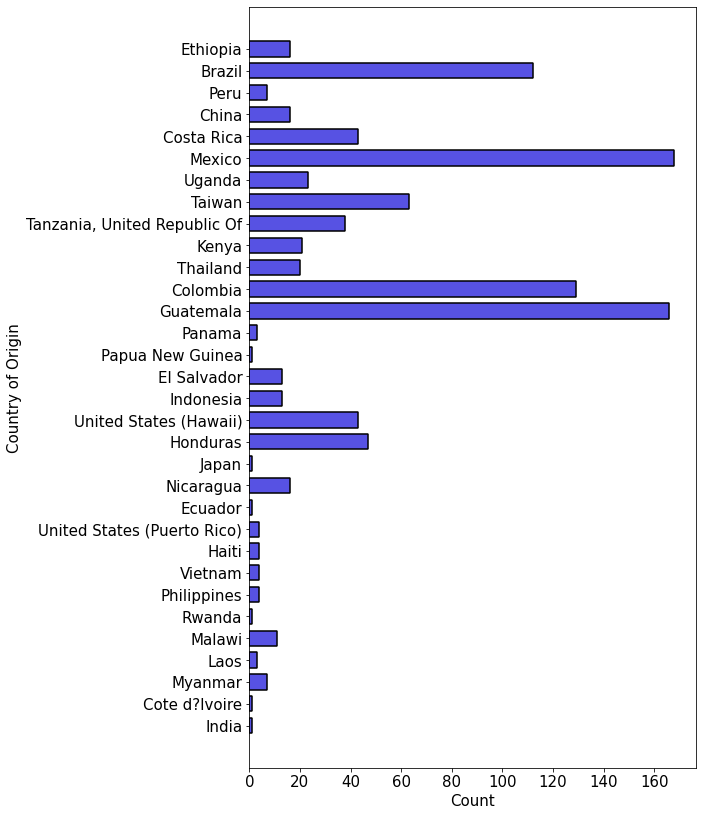

In [103]:
plt.figure(figsize=(8, 14))
ax = sns.histplot(data=df_cleaned, y="Country.of.Origin", shrink=.7);
ax.set(ylabel="Country of Origin");

### Altitude

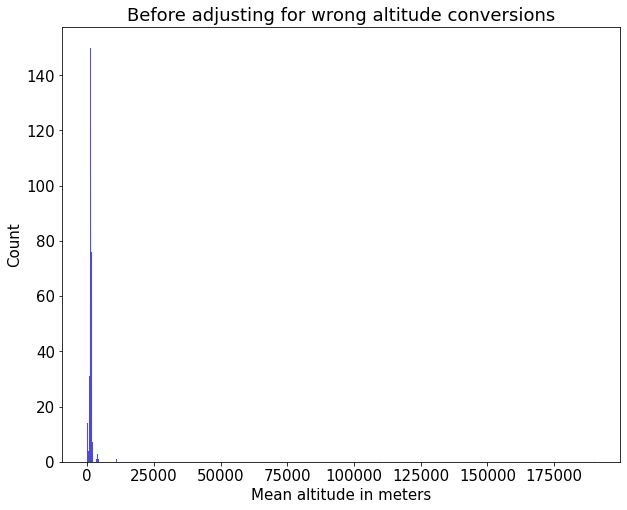

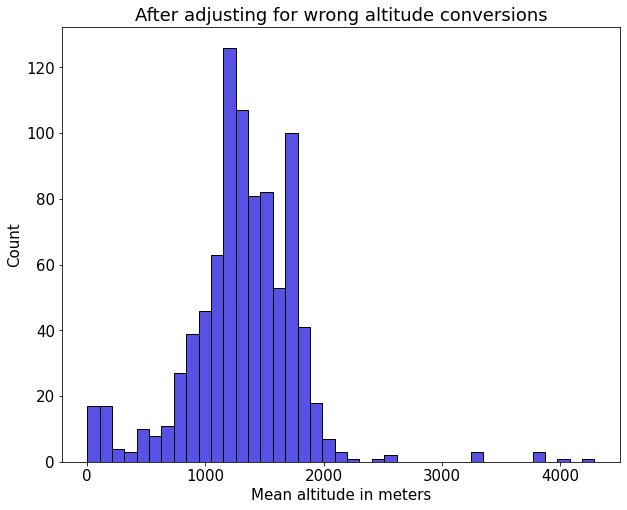

In [104]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="Before adjusting for wrong altitude conversions");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="After adjusting for wrong altitude conversions");

### Cupping results

Overall average of tested beans: 82.12182000000001
Overall standard deviation of tested beans: 2.611879208654298
Minimum of tested beans: 59.83
Maximum of tested beans: 90.58


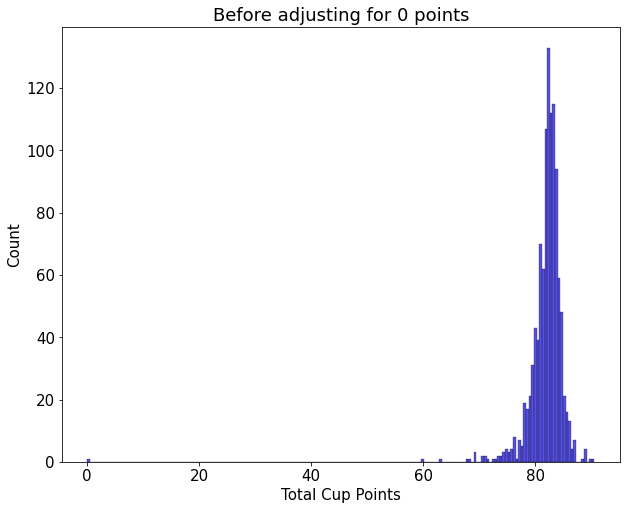

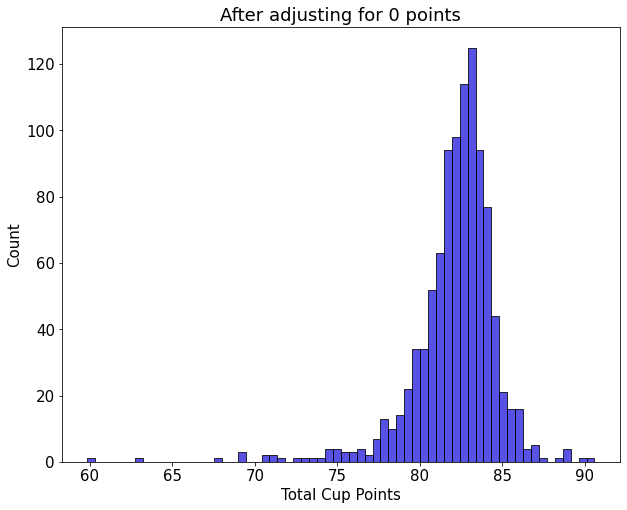

In [105]:
print("Overall average of tested beans: {}".format(df_cleaned["Total.Cup.Points"].mean()))
print("Overall standard deviation of tested beans: {}".format(df_cleaned["Total.Cup.Points"].std()))
print("Minimum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].min()))
print("Maximum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].max()))

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_type_adjusted, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="Before adjusting for 0 points");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="After adjusting for 0 points");

<Figure size 720x1440 with 0 Axes>

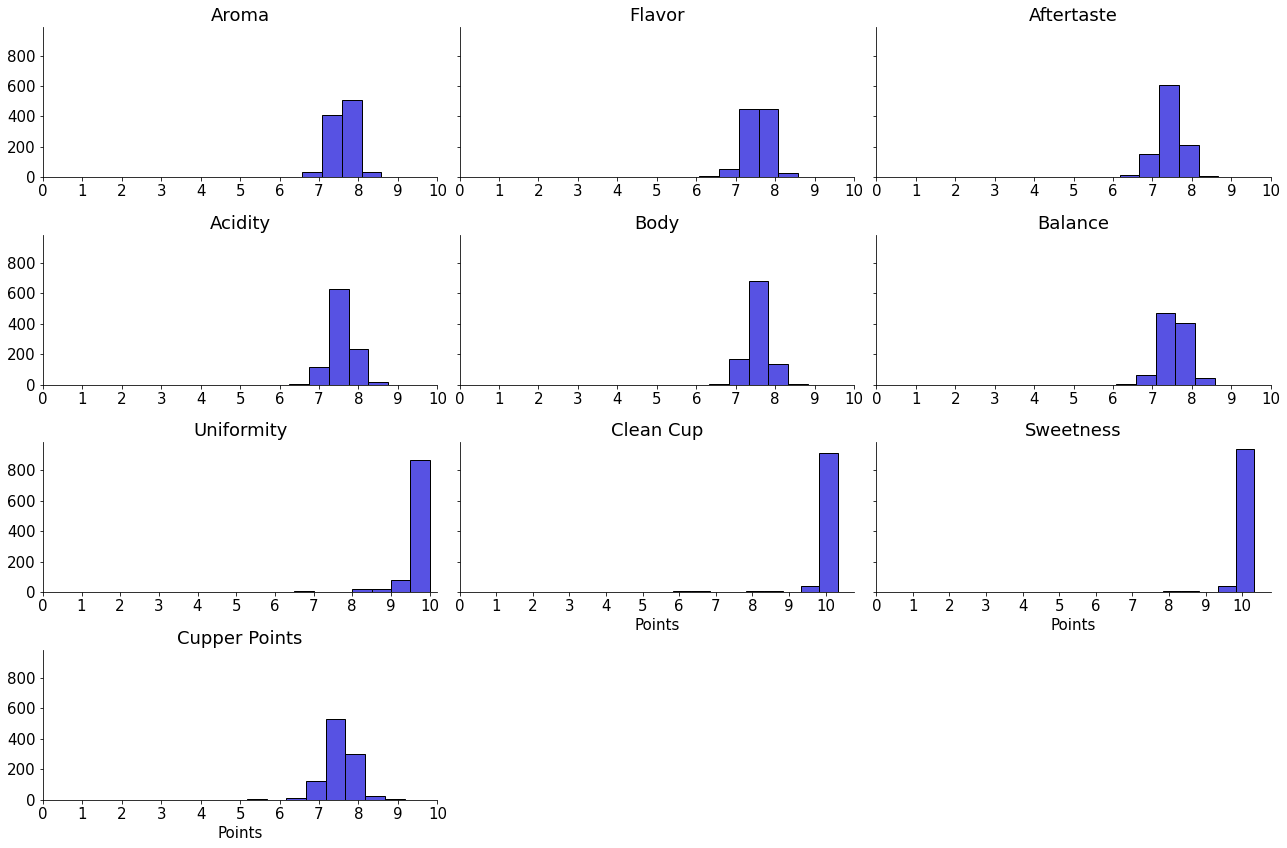

In [106]:
df_melted = df_cleaned[metric_features].melt()
df_melted = df_melted.round(2)
df_melted["value"] = df_melted["value"].astype("float64")
plt.figure(figsize=(10, 20))
g = sns.FacetGrid(df_melted, col='variable', col_wrap=3, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, "value", binwidth=0.5)
g.set(xticks=range(0, 11, 1))
g.set_xlabels("Points")
metric_titles = list(map(lambda metric: str.replace(metric, ".", " "), metric_features))
axes = g.axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    ax.set_title(metric_titles[i])

### Color


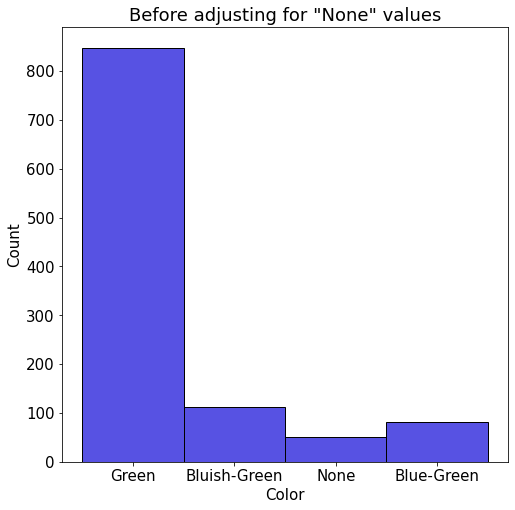

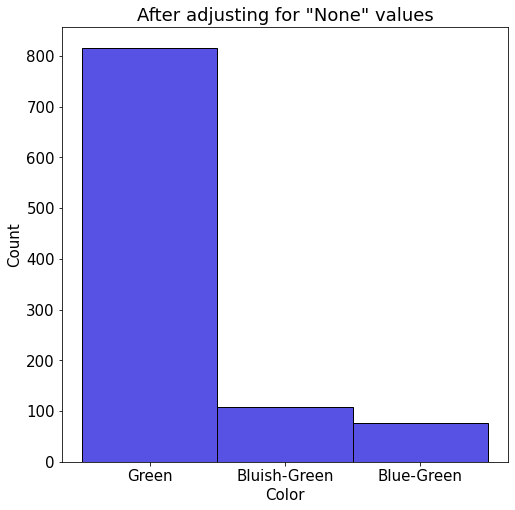

In [107]:
plt.figure(figsize=(8, 8))
ax = sns.histplot(data=df_type_adjusted, x="Color")
ax.set(xlabel="Color", title="Before adjusting for \"None\" values");


plt.figure(figsize=(8, 8))
ax = sns.histplot(data=df_cleaned, x="Color")
ax.set(xlabel="Color", title="After adjusting for \"None\" values");

### Processing Method

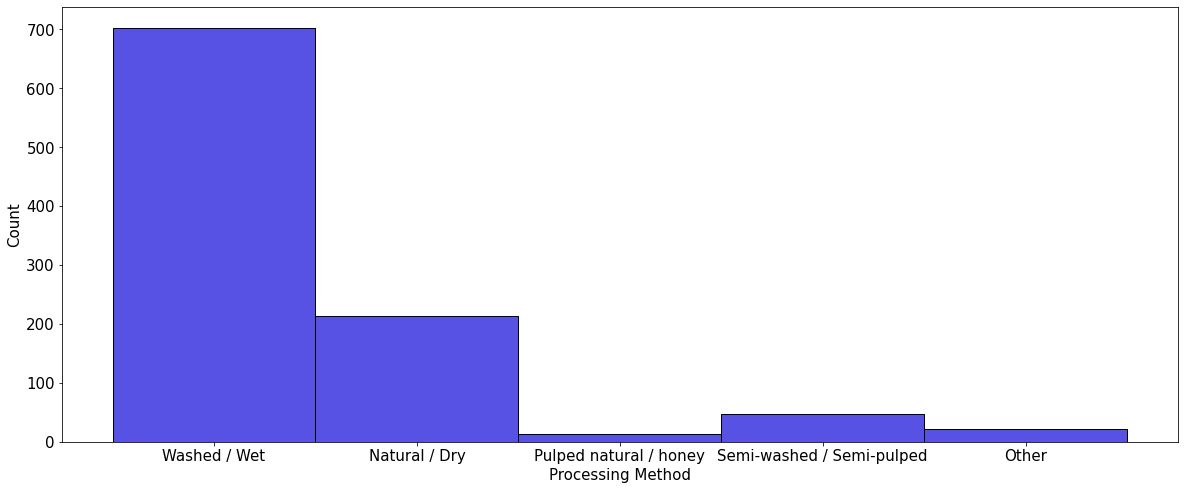

In [108]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=df_cleaned, x="Processing.Method")
ax.set(xlabel="Processing Method");

### Total weight

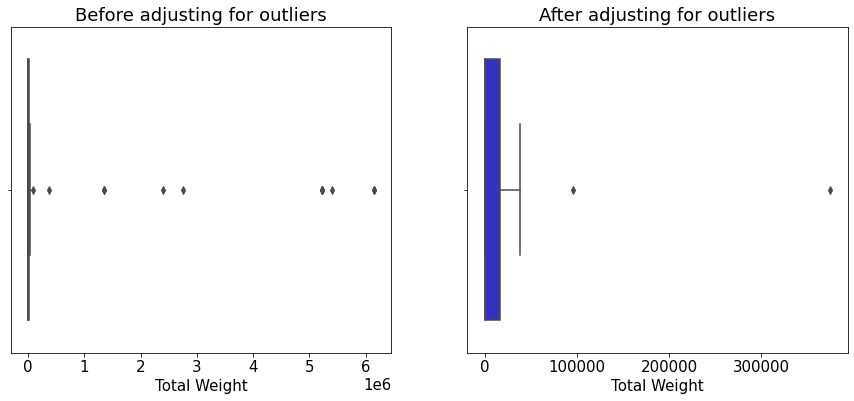

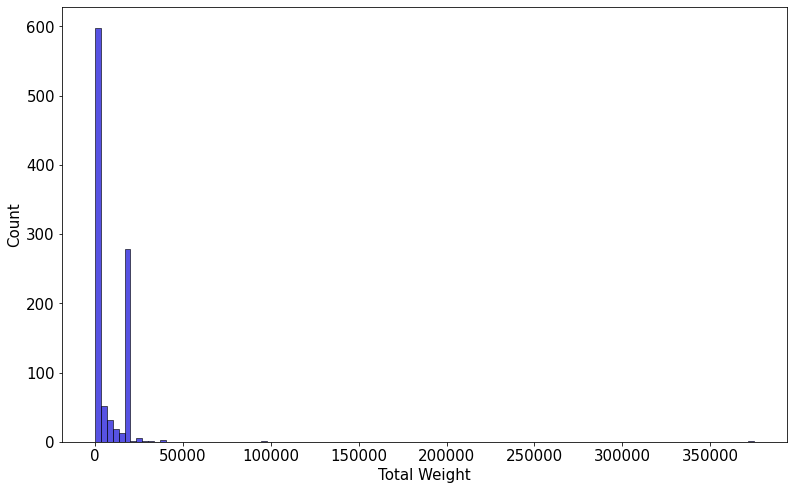

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6));
sns.boxplot(x=df_type_adjusted["Weight.Total"], ax=ax1)
ax1.set(xlabel="Total Weight", title="Before adjusting for outliers");
sns.boxplot(x=df_cleaned["Weight.Total"], ax=ax2);
ax2.set(xlabel="Total Weight", title="After adjusting for outliers");

plt.figure(figsize=(13, 8))
ax = sns.histplot(data=df_cleaned, x="Weight.Total")
ax.set(xlabel="Total Weight");